In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
spark = SparkSession.builder.appName('Iteration 4_Sly').getOrCreate()
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
df = spark.read.csv('./AppleStore.csv', header=True)

In [3]:
#-------------------------------------------------Step 2 Data Understanding-------------------------------------------------
print(df.count(),len(df.columns))

7197 17


In [4]:
pandasdf = df.toPandas()
display(pandasdf.head(5))
display(pandasdf.tail(5))

,_c0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0,161065,26,4,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0,262241,649,4,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0,985920,5320,4.5,5,7.5.1,4+,Reference,37,5,45,1


,_c0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
7192,11081,1187617475,Kubik,126644224,USD,0,142,75,4.5,4.5,1.3,4+,Games,38,5,1,1
7193,11082,1187682390,VR Roller-Coaster,120760320,USD,0,30,30,4.5,4.5,0.9,4+,Games,38,0,1,1
7194,11087,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,USD,1.99,15,0,4.5,0,1.0.2,9+,Utilities,37,1,1,1
7195,11089,1187838770,VR Roller Coaster World - Virtual Reality,97235968,USD,0,85,32,4.5,4.5,1.0.15,12+,Games,38,0,2,1
7196,11097,1188375727,Escape the Sweet Shop Series,90898432,USD,0,3,3,5,5,1.0,4+,Games,40,0,2,1


In [5]:
df.dtypes

[('_c0', 'string'),
 ('id', 'string'),
 ('track_name', 'string'),
 ('size_bytes', 'string'),
 ('currency', 'string'),
 ('price', 'string'),
 ('rating_count_tot', 'string'),
 ('rating_count_ver', 'string'),
 ('user_rating', 'string'),
 ('user_rating_ver', 'string'),
 ('ver', 'string'),
 ('cont_rating', 'string'),
 ('prime_genre', 'string'),
 ('sup_devices.num', 'string'),
 ('ipadSc_urls.num', 'string'),
 ('lang.num', 'string'),
 ('vpp_lic', 'string')]

In [6]:
print(df.collect()[0])
print(df.collect()[-1])

Row(_c0='1', id='281656475', track_name='PAC-MAN Premium', size_bytes='100788224', currency='USD', price='3.99', rating_count_tot='21292', rating_count_ver='26', user_rating='4', user_rating_ver='4.5', ver='6.3.5', cont_rating='4+', prime_genre='Games', sup_devices.num='38', ipadSc_urls.num='5', lang.num='10', vpp_lic='1')
Row(_c0='11097', id='1188375727', track_name='Escape the Sweet Shop Series', size_bytes='90898432', currency='USD', price='0', rating_count_tot='3', rating_count_ver='3', user_rating='5', user_rating_ver='5', ver='1.0', cont_rating='4+', prime_genre='Games', sup_devices.num='40', ipadSc_urls.num='0', lang.num='2', vpp_lic='1')


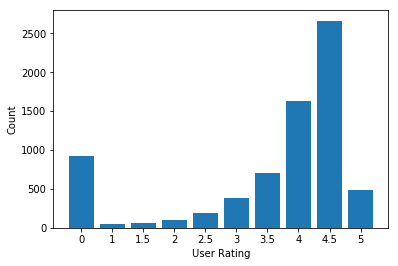

In [7]:
dfbar = df.groupby('user_rating').count().orderBy(df.user_rating.asc())
dfbar_x = dfbar.toPandas()['user_rating'].values.tolist()
dfbar_y = dfbar.toPandas()['count'].values.tolist()
plt.bar(dfbar_x, dfbar_y)
plt.xlabel('User Rating')
plt.ylabel('Count')
plt.show()

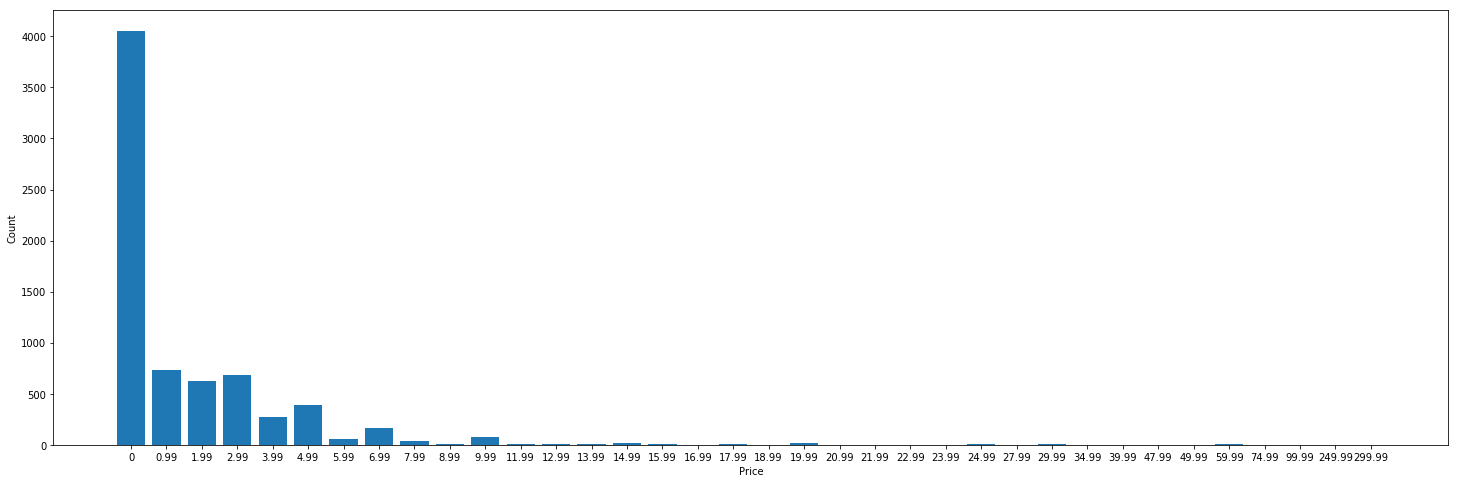

In [8]:
plt.figure(figsize=(25,8))
dfbar2 = df.groupby('price').count().orderBy(df.price.cast('float').asc())
dfbar2_x = dfbar2.toPandas()['price'].values.tolist()
dfbar2_y = dfbar2.toPandas()['count'].values.tolist()
plt.bar(dfbar2_x, dfbar2_y)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

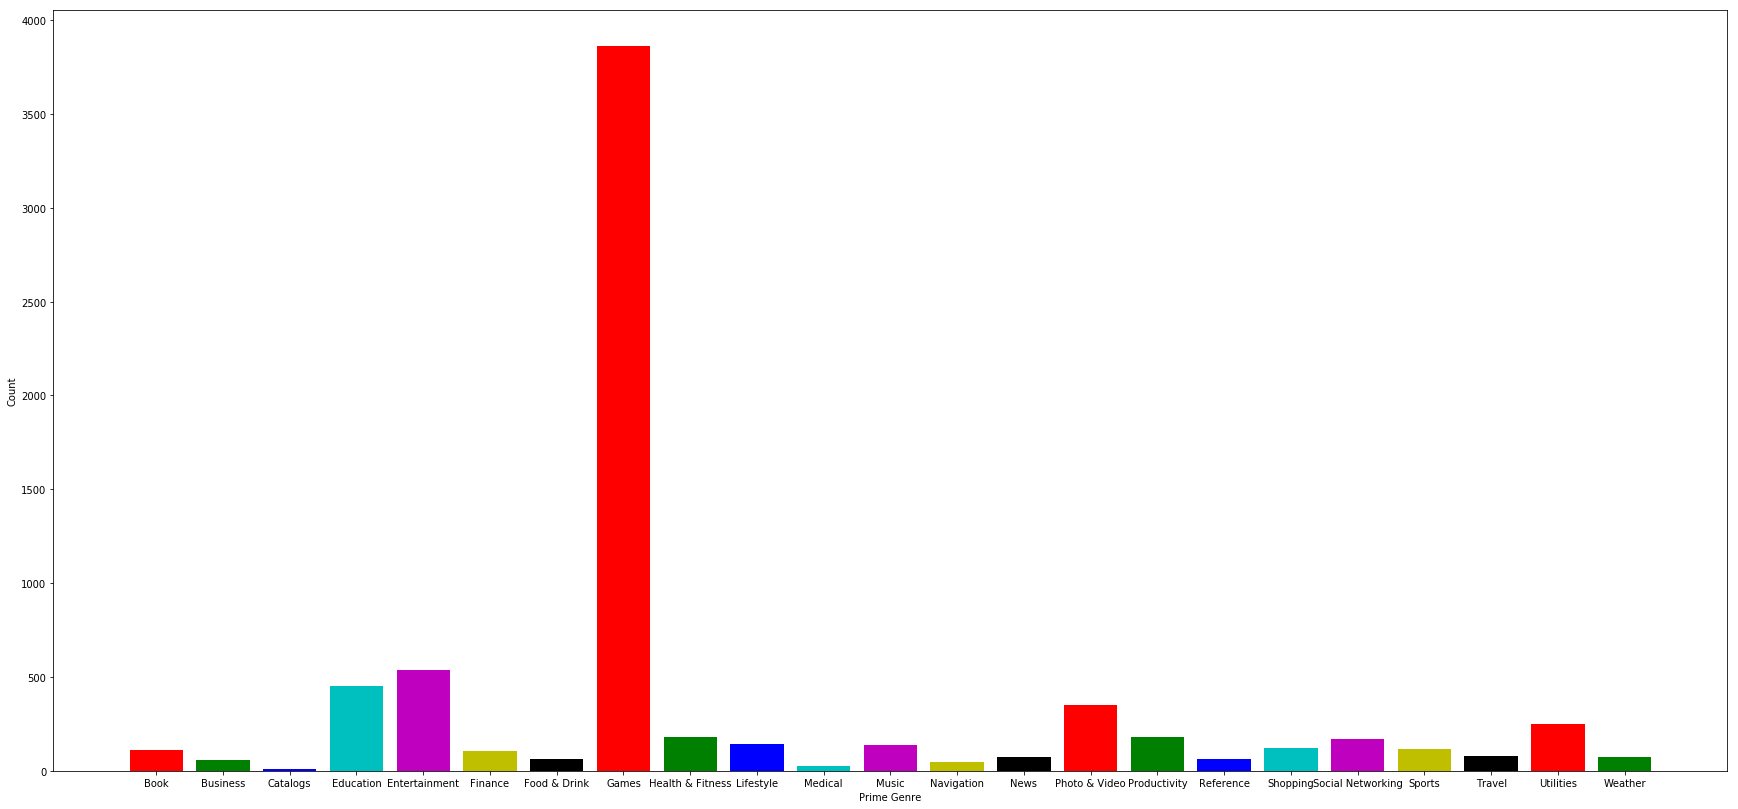

In [9]:
plt.figure(figsize=(30,14))
dfbar3 = df.groupby('prime_genre').count().orderBy(df.prime_genre.asc())
dfbar3_x = dfbar3.toPandas()['prime_genre'].values.tolist()
dfbar3_y = dfbar3.toPandas()['count'].values.tolist()
plt.bar(dfbar3_x, dfbar3_y, color=['r','g','b','c','m','y','k'])
plt.xlabel('Prime Genre')
plt.ylabel('Count')
plt.show()

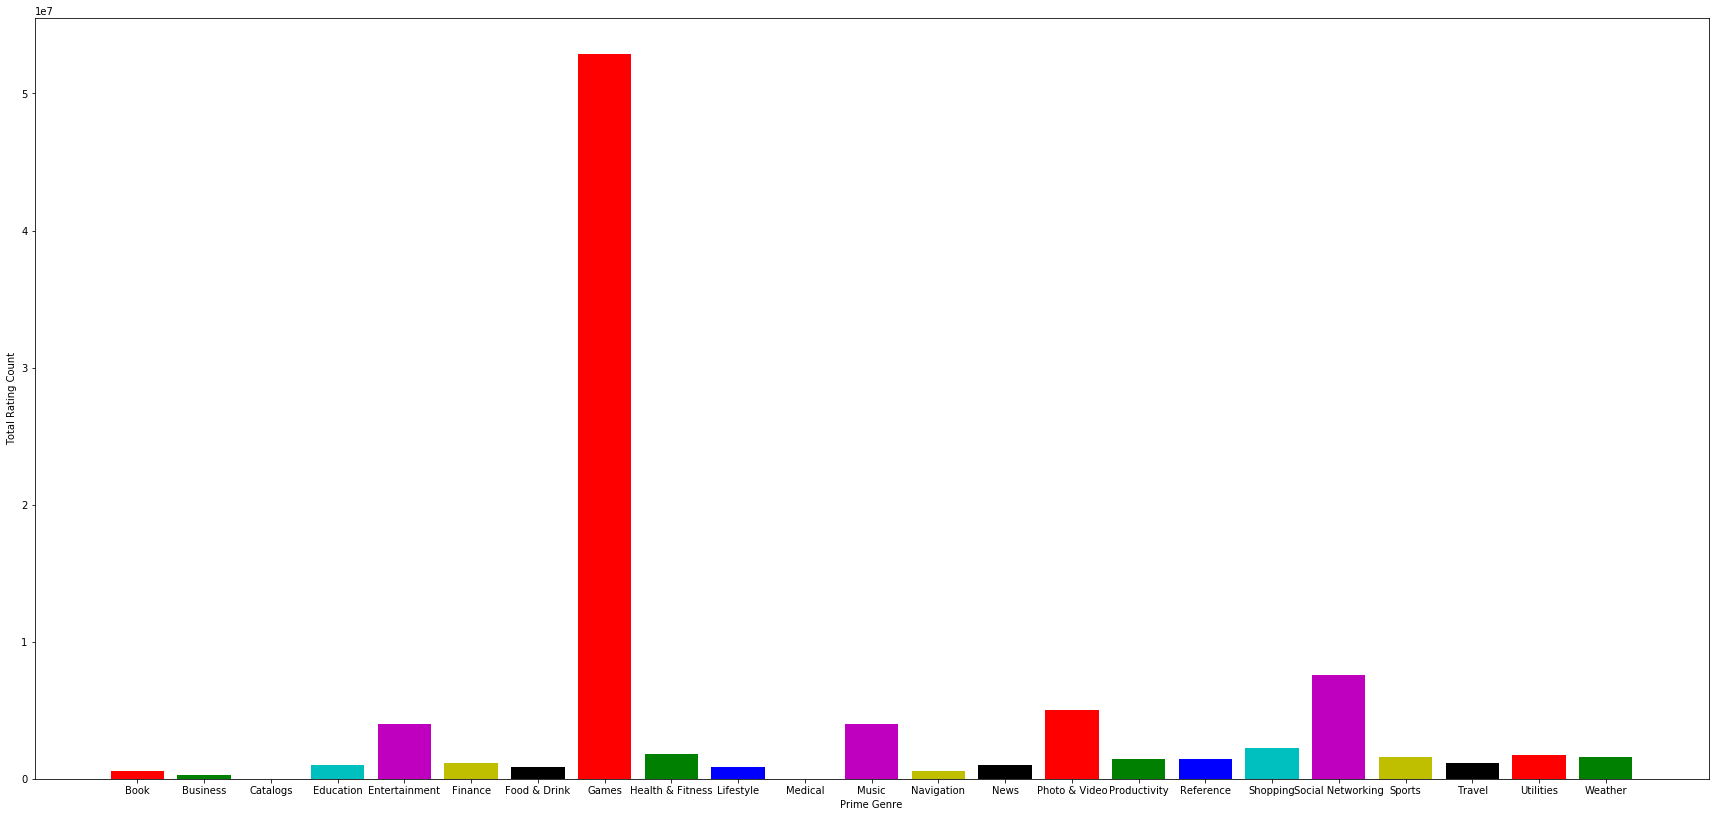

In [10]:
plt.figure(figsize=(30,14))
df2 = df
df2 = df.withColumn('rating_count_tot',df.rating_count_tot.cast('int'))
dfbar4 = df2.groupby('prime_genre').sum('rating_count_tot').orderBy(df2.prime_genre.asc())
dfbar4_x = dfbar4.toPandas()['prime_genre'].values.tolist()
dfbar4_y = dfbar4.toPandas()['sum(rating_count_tot)'].values.tolist()
plt.bar(dfbar4_x, dfbar4_y, color=['r','g','b','c','m','y','k'])
plt.xlabel('Prime Genre')
plt.ylabel('Total Rating Count')
plt.show()

In [11]:
print(pandasdf['track_name'].head(5))
print(pandasdf['ver'].head(5))
print(pandasdf['currency'].head(5))
print(pandasdf['cont_rating'].head(5))
print(pandasdf['prime_genre'].head(5))
print(pandasdf['ipadSc_urls.num'].head(5))
print(pandasdf['vpp_lic'].head(5))

0                                      PAC-MAN Premium
1                            Evernote - stay organized
2      WeatherBug - Local Weather, Radar, Maps, Alerts
3    eBay: Best App to Buy, Sell, Save! Online Shop...
4                                                Bible
Name: track_name, dtype: object
0     6.3.5
1     8.2.2
2     5.0.0
3    5.10.0
4     7.5.1
Name: ver, dtype: object
0    USD
1    USD
2    USD
3    USD
4    USD
Name: currency, dtype: object
0     4+
1     4+
2     4+
3    12+
4     4+
Name: cont_rating, dtype: object
0           Games
1    Productivity
2         Weather
3        Shopping
4       Reference
Name: prime_genre, dtype: object
0    5
1    5
2    5
3    5
4    5
Name: ipadSc_urls.num, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: vpp_lic, dtype: object


In [12]:
print('currency',pandasdf['currency'].unique())
print('cont_rating',pandasdf['cont_rating'].unique())
print('prime_genre',pandasdf['prime_genre'].unique())
print('ipadSc_urls.num',pandasdf['ipadSc_urls.num'].unique())
print('vpp_lic',pandasdf['vpp_lic'].unique())

currency ['USD']
cont_rating ['4+' '12+' '17+' '9+']
prime_genre ['Games' 'Productivity' 'Weather' 'Shopping' 'Reference' 'Finance' 'Music'
 'Utilities' 'Travel' 'Social Networking' 'Sports' 'Business'
 'Health & Fitness' 'Entertainment' 'Photo & Video' 'Navigation'
 'Education' 'Lifestyle' 'Food & Drink' 'News' 'Book' 'Medical' 'Catalogs']
ipadSc_urls.num ['5' '0' '4' '1' '3' '2']
vpp_lic ['1' '0']


In [13]:
print(pandasdf.isnull().sum())

_c0                 0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64


In [14]:
df2 = df2.withColumnRenamed('sup_devices.num','sup_devicesnum').withColumnRenamed('lang.num','langnum')
df2 = df2.withColumn('sup_devicesnum',df2.sup_devicesnum.cast('int')).withColumn('langnum',df2.langnum.cast('int'))
df.describe('size_bytes').show()
df.describe('rating_count_tot').show()
df.describe('rating_count_ver').show()
df2.describe('sup_devicesnum').show()
df2.describe('langnum').show()

+-------+-------------------+
|summary|         size_bytes|
+-------+-------------------+
|  count|               7197|
|   mean| 1.99134453825066E8|
| stddev|3.592069135387029E8|
|    min|          100000768|
|    max|           99992576|
+-------+-------------------+

+-------+------------------+
|summary|  rating_count_tot|
+-------+------------------+
|  count|              7197|
|   mean|12892.907183548701|
| stddev| 75739.40867472602|
|    min|                 0|
|    max|               999|
+-------+------------------+

+-------+------------------+
|summary|  rating_count_ver|
+-------+------------------+
|  count|              7197|
|   mean| 460.3739057940809|
| stddev|3920.4551833619757|
|    min|                 0|
|    max|               999|
+-------+------------------+

+-------+------------------+
|summary|    sup_devicesnum|
+-------+------------------+
|  count|              7197|
|   mean| 37.36181742392664|
| stddev|3.7377152388584527|
|    min|                 9|
| 

In [15]:
#-----------------------------------------------------Step 3 Preparation-----------------------------------------------------
df3 = df
df3 = df3.withColumnRenamed('_c0','No').withColumnRenamed('id','ID').withColumnRenamed('track_name','AppName')
df3 = df3.withColumnRenamed('size_bytes','AppSize_Bytes').withColumnRenamed('currency','Currency').withColumnRenamed('price','Price')
df3 = df3.withColumnRenamed('rating_count_tot','TotalRatingCount').withColumnRenamed('rating_count_ver','TotalRatingCount_CurrentVersion')
df3 = df3.withColumnRenamed('user_rating','UserRating').withColumnRenamed('user_rating_ver','UserRating_CurrentVersion')
df3 = df3.withColumnRenamed('ver','Version').withColumnRenamed('cont_rating','AppRestriction').withColumnRenamed('prime_genre','AppType')
df3 = df3.withColumnRenamed('sup_devices.num','SupportDeviceNum').withColumnRenamed('ipadSc_urls.num','DisplayedScreenshotNum')
df3 = df3.withColumnRenamed('lang.num','SupportLanguageNum').withColumnRenamed('vpp_lic','VppLicense')
print('Old Columns Name:',df.columns)
print('New Columns Nmae:',df3.columns)

Old Columns Name: ['_c0', 'id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']
New Columns Nmae: ['No', 'ID', 'AppName', 'AppSize_Bytes', 'Currency', 'Price', 'TotalRatingCount', 'TotalRatingCount_CurrentVersion', 'UserRating', 'UserRating_CurrentVersion', 'Version', 'AppRestriction', 'AppType', 'SupportDeviceNum', 'DisplayedScreenshotNum', 'SupportLanguageNum', 'VppLicense']


In [16]:
df3 = df3.withColumn('No',df3.No.cast('int'))
df3 = df3.withColumn('ID',df3.ID.cast('int'))
df3 = df3.withColumn('AppSize_Bytes',df3.AppSize_Bytes.cast('int'))
df3 = df3.withColumn('Price',df3.Price.cast('float'))
df3 = df3.withColumn('TotalRatingCount',df3.TotalRatingCount.cast('int'))
df3 = df3.withColumn('TotalRatingCount_CurrentVersion',df3.TotalRatingCount_CurrentVersion.cast('int'))
df3 = df3.withColumn('UserRating',df3.UserRating.cast('float'))
df3 = df3.withColumn('UserRating_CurrentVersion',df3.UserRating_CurrentVersion.cast('float'))
df3 = df3.withColumn('SupportDeviceNum',df3.SupportDeviceNum.cast('int'))
df3 = df3.withColumn('DisplayedScreenshotNum',df3.DisplayedScreenshotNum.cast('int'))
df3 = df3.withColumn('SupportLanguageNum',df3.SupportLanguageNum.cast('int'))
df3 = df3.withColumn('VppLicense',df3.VppLicense.cast('int'))
df3.dtypes

[('No', 'int'),
 ('ID', 'int'),
 ('AppName', 'string'),
 ('AppSize_Bytes', 'int'),
 ('Currency', 'string'),
 ('Price', 'float'),
 ('TotalRatingCount', 'int'),
 ('TotalRatingCount_CurrentVersion', 'int'),
 ('UserRating', 'float'),
 ('UserRating_CurrentVersion', 'float'),
 ('Version', 'string'),
 ('AppRestriction', 'string'),
 ('AppType', 'string'),
 ('SupportDeviceNum', 'int'),
 ('DisplayedScreenshotNum', 'int'),
 ('SupportLanguageNum', 'int'),
 ('VppLicense', 'int')]

In [17]:
df3.createOrReplaceTempView("0_rating")
spark.sql('select ID,TotalRatingCount,UserRating from 0_rating where TotalRatingCount = 0 and UserRating = 0').show()
spark.sql('select count(*) as 0_Rating_Apps_Num from 0_rating where TotalRatingCount = 0 and UserRating = 0').show()

+---------+----------------+----------+
|       ID|TotalRatingCount|UserRating|
+---------+----------------+----------+
|329174056|               0|       0.0|
|350480010|               0|       0.0|
|355709084|               0|       0.0|
|377321278|               0|       0.0|
|379256460|               0|       0.0|
|389543438|               0|       0.0|
|391947489|               0|       0.0|
|394342281|               0|       0.0|
|398166286|               0|       0.0|
|404529222|               0|       0.0|
|411608323|               0|       0.0|
|413246702|               0|       0.0|
|413487517|               0|       0.0|
|422845617|               0|       0.0|
|432278816|               0|       0.0|
|432455516|               0|       0.0|
|436180275|               0|       0.0|
|443324720|               0|       0.0|
|445300213|               0|       0.0|
|447024088|               0|       0.0|
+---------+----------------+----------+
only showing top 20 rows

+-------------

In [18]:
null_rating =  df3.withColumn(
    'UserRating',
    when(
        col('UserRating') == 0, None
    ).otherwise(col('UserRating'))
)
null_rating.createOrReplaceTempView("null_rating")
spark.sql('select count(*) as Null_Rating_Apps_Num from null_rating where UserRating is null').show()
print(100 - null_rating.na.drop(subset=['UserRating']).count()/null_rating.count() * 100)

+--------------------+
|Null_Rating_Apps_Num|
+--------------------+
|                 929|
+--------------------+

12.90815617618452


In [19]:
df3 = null_rating
df3_1 = df3.na.drop(subset=['UserRating'])
print(df3_1.count(),len(df3_1.columns))

6268 17


In [20]:
rating_level = df3_1.withColumn(
    'UserRating',
    when(col('UserRating') <= 3.5, 'Low Rating').when(col('UserRating') > 3.5, 'High Rating')
)
df3_1.select('UserRating').show()
rating_level.select('UserRating').show()

+----------+
|UserRating|
+----------+
|       4.0|
|       4.0|
|       3.5|
|       4.0|
|       4.5|
|       4.0|
|       4.0|
|       4.0|
|       4.5|
|       4.0|
|       4.5|
|       3.5|
|       3.5|
|       3.5|
|       4.5|
|       4.0|
|       3.5|
|       4.0|
|       4.0|
|       4.0|
+----------+
only showing top 20 rows

+-----------+
| UserRating|
+-----------+
|High Rating|
|High Rating|
| Low Rating|
|High Rating|
|High Rating|
|High Rating|
|High Rating|
|High Rating|
|High Rating|
|High Rating|
|High Rating|
| Low Rating|
| Low Rating|
| Low Rating|
|High Rating|
|High Rating|
| Low Rating|
|High Rating|
|High Rating|
|High Rating|
+-----------+
only showing top 20 rows



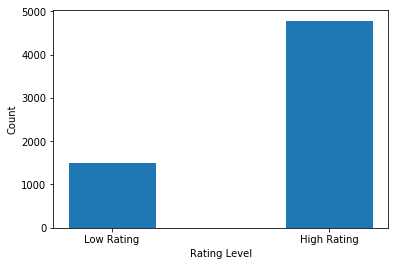

In [21]:
rating_level_bar = rating_level.groupby('UserRating').count()
rating_level_x = rating_level_bar.toPandas()['UserRating'].values.tolist()
rating_level_y = rating_level_bar.toPandas()['count'].values.tolist()
plt.bar(rating_level_x, rating_level_y, width = 0.4)
plt.xlabel('Rating Level')
plt.ylabel('Count')
plt.show()

In [22]:
rating_level = rating_level.withColumn('RatingLevel',rating_level.UserRating)
rating_level_2 = rating_level.select('ID','RatingLevel')
df3_2 = df3_1.join(rating_level_2, ['ID'], 'outer')
df3_2 = df3_2.drop('No','AppName','Currency','UserRating','UserRating_CurrentVersion','Version')
print(df3_2.columns)

['ID', 'AppSize_Bytes', 'Price', 'TotalRatingCount', 'TotalRatingCount_CurrentVersion', 'AppRestriction', 'AppType', 'SupportDeviceNum', 'DisplayedScreenshotNum', 'SupportLanguageNum', 'VppLicense', 'RatingLevel']


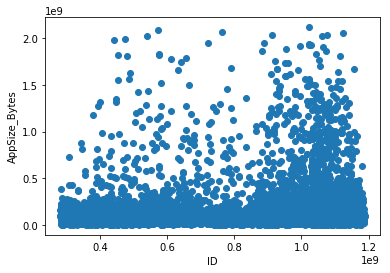

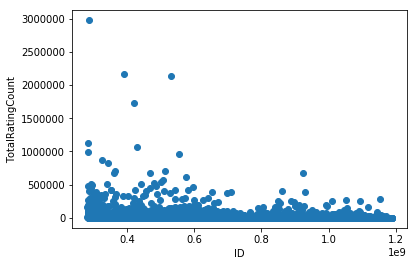

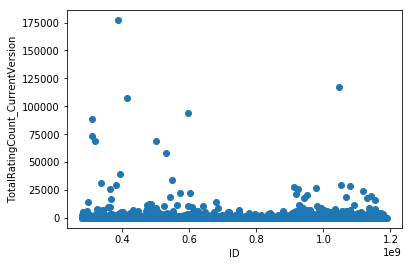

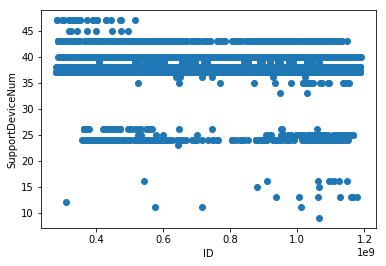

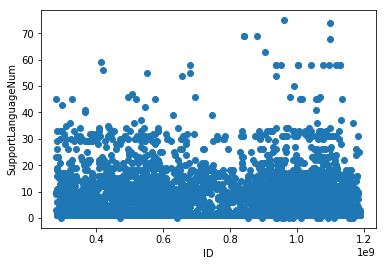

In [23]:
pandasdf3_2 = df3_2.toPandas()
plt.scatter(x=pandasdf3_2['ID'], y=pandasdf3_2['AppSize_Bytes'])
plt.xlabel('ID')
plt.ylabel('AppSize_Bytes')
plt.show()
pandasdf3_2 = df3_2.toPandas()
plt.scatter(x=pandasdf3_2['ID'], y=pandasdf3_2['TotalRatingCount'])
plt.xlabel('ID')
plt.ylabel('TotalRatingCount')
plt.show()
pandasdf3_2 = df3_2.toPandas()
plt.scatter(x=pandasdf3_2['ID'], y=pandasdf3_2['TotalRatingCount_CurrentVersion'])
plt.xlabel('ID')
plt.ylabel('TotalRatingCount_CurrentVersion')
plt.show()
pandasdf3_2 = df3_2.toPandas()
plt.scatter(x=pandasdf3_2['ID'], y=pandasdf3_2['SupportDeviceNum'])
plt.xlabel('ID')
plt.ylabel('SupportDeviceNum')
plt.show()
pandasdf3_2 = df3_2.toPandas()
plt.scatter(x=pandasdf3_2['ID'], y=pandasdf3_2['SupportLanguageNum'])
plt.xlabel('ID')
plt.ylabel('SupportLanguageNum')
plt.show()

In [24]:
treat_outlier = df3_2.select('ID','AppSize_Bytes','TotalRatingCount','TotalRatingCount_CurrentVersion',
                             'SupportDeviceNum','SupportLanguageNum')

treat_outlier.selectExpr('percentile(AppSize_Bytes, 0.01)').show() #3900805.12
treat_outlier.selectExpr('percentile(AppSize_Bytes, 0.99)').show() #1.4759723622399957E
treat_outlier =  treat_outlier.withColumn('AppSize_Bytes',
    when(col('AppSize_Bytes') < 3900805.12, 3900805.12
        ).when((col('AppSize_Bytes') >= 3900805.12) & (col('AppSize_Bytes') <= 1.4759723622399957E9),col('AppSize_Bytes')
              ).when(col('AppSize_Bytes') > 1.4759723622399957E9, 1.4759723622399957E9)
) 
treat_outlier.selectExpr('percentile(TotalRatingCount, 0.01)').show() #1.0
treat_outlier.selectExpr('percentile(TotalRatingCount, 0.99)').show() #288713.30999999976
treat_outlier =  treat_outlier.withColumn('TotalRatingCount',
    when(col('TotalRatingCount') < 1.0, 1.0
        ).when((col('TotalRatingCount') >= 1.0) & (col('TotalRatingCount') <= 288713.30999999976),col('TotalRatingCount')
              ).when(col('TotalRatingCount') > 288713.30999999976, 288713.30999999976)
) 
treat_outlier.selectExpr('percentile(TotalRatingCount_CurrentVersion, 0.01)').show() #0.0
treat_outlier.selectExpr('percentile(TotalRatingCount_CurrentVersion, 0.99)').show() #7072.53999999999
treat_outlier =  treat_outlier.withColumn('TotalRatingCount_CurrentVersion',
    when(col('TotalRatingCount_CurrentVersion') < 0.0, 0.0
        ).when((col('TotalRatingCount_CurrentVersion') >= 0.0) & (col('TotalRatingCount_CurrentVersion') <= 7072.53999999999),
               col('TotalRatingCount_CurrentVersion')
              ).when(col('TotalRatingCount_CurrentVersion') > 7072.53999999999, 7072.53999999999)
)
treat_outlier.selectExpr('percentile(SupportDeviceNum, 0.01)').show() #24.0
treat_outlier.selectExpr('percentile(SupportDeviceNum, 0.99)').show() #43.0
treat_outlier =  treat_outlier.withColumn('SupportDeviceNum',
    when(col('SupportDeviceNum') < 24.0, 24.0
        ).when((col('SupportDeviceNum') >= 24.0) & (col('SupportDeviceNum') <= 43.0),col('SupportDeviceNum')
              ).when(col('SupportDeviceNum') > 43.0, 43.0)
)
treat_outlier.selectExpr('percentile(SupportLanguageNum, 0.01)').show() #1.0
treat_outlier.selectExpr('percentile(SupportLanguageNum, 0.99)').show() #34.0
treat_outlier =  treat_outlier.withColumn('SupportLanguageNum',
    when(col('SupportLanguageNum') < 1.0, 1.0
        ).when((col('SupportLanguageNum') >= 1.0) & (col('SupportLanguageNum') <= 34.0),col('SupportLanguageNum')
              ).when(col('SupportLanguageNum') > 34.0, 34.0)
)

+-----------------------------------------------+
|percentile(AppSize_Bytes, CAST(0.01 AS DOUBLE))|
+-----------------------------------------------+
|                                     3900805.12|
+-----------------------------------------------+

+-----------------------------------------------+
|percentile(AppSize_Bytes, CAST(0.99 AS DOUBLE))|
+-----------------------------------------------+
|                           1.4759723622399957E9|
+-----------------------------------------------+

+--------------------------------------------------+
|percentile(TotalRatingCount, CAST(0.01 AS DOUBLE))|
+--------------------------------------------------+
|                                               1.0|
+--------------------------------------------------+

+--------------------------------------------------+
|percentile(TotalRatingCount, CAST(0.99 AS DOUBLE))|
+--------------------------------------------------+
|                                288713.30999999976|
+-------------------

In [25]:
pandastreat_outlier = treat_outlier.toPandas()
print(pandasdf3_2['AppSize_Bytes'].skew())
print(pandastreat_outlier['AppSize_Bytes'].skew())
print(pandasdf3_2['TotalRatingCount'].skew())
print(pandastreat_outlier['TotalRatingCount'].skew())
print(pandasdf3_2['TotalRatingCount_CurrentVersion'].skew())
print(pandastreat_outlier['TotalRatingCount_CurrentVersion'].skew())
print(pandasdf3_2['SupportDeviceNum'].skew())
print(pandastreat_outlier['SupportDeviceNum'].skew())
print(pandasdf3_2['SupportLanguageNum'].skew())
print(pandastreat_outlier['SupportLanguageNum'].skew())

3.4269466017906467
3.0687276714790577
18.335633918081488
5.291701155192468
24.688606609845642
5.198052964717038
-2.595233323345456
-2.391435685739513
2.7091018590900244
1.9221128968769046


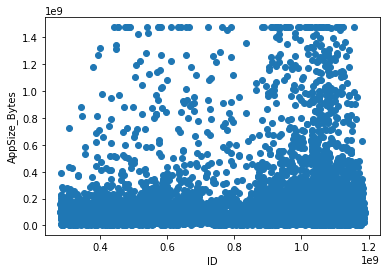

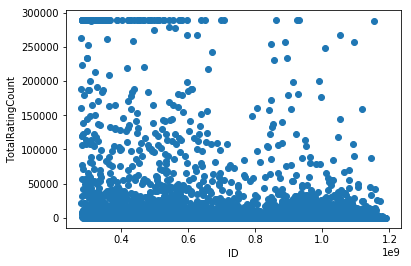

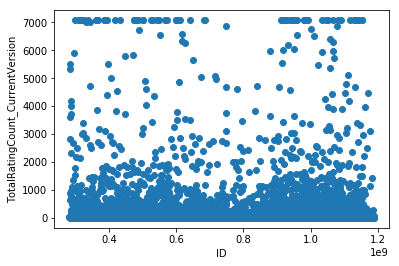

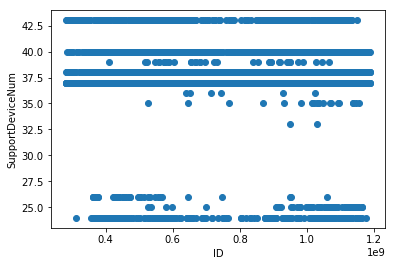

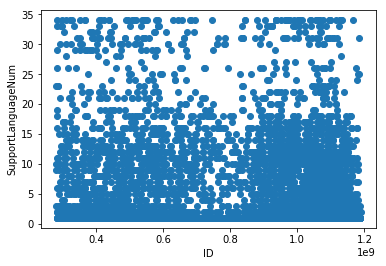

In [26]:
plt.scatter(x=pandastreat_outlier['ID'], y=pandastreat_outlier['AppSize_Bytes'])
plt.xlabel('ID')
plt.ylabel('AppSize_Bytes')
plt.show()
plt.scatter(x=pandastreat_outlier['ID'], y=pandastreat_outlier['TotalRatingCount'])
plt.xlabel('ID')
plt.ylabel('TotalRatingCount')
plt.show()
plt.scatter(x=pandastreat_outlier['ID'], y=pandastreat_outlier['TotalRatingCount_CurrentVersion'])
plt.xlabel('ID')
plt.ylabel('TotalRatingCount_CurrentVersion')
plt.show()
plt.scatter(x=pandastreat_outlier['ID'], y=pandastreat_outlier['SupportDeviceNum'])
plt.xlabel('ID')
plt.ylabel('SupportDeviceNum')
plt.show()
plt.scatter(x=pandastreat_outlier['ID'], y=pandastreat_outlier['SupportLanguageNum'])
plt.xlabel('ID')
plt.ylabel('SupportLanguageNum')
plt.show()

In [27]:
df3_2.describe('AppSize_Bytes').show()
df3_2.describe('TotalRatingCount').show()
df3_2.describe('TotalRatingCount_CurrentVersion').show()
df3_2.describe('SupportDeviceNum').show()
df3_2.describe('SupportLanguageNum').show()

+-------+-------------------+
|summary|      AppSize_Bytes|
+-------+-------------------+
|  count|               6224|
|   mean|1.877444161646851E8|
| stddev|2.775693251391134E8|
|    min|             589824|
|    max|         2116109312|
+-------+-------------------+

+-------+------------------+
|summary|  TotalRatingCount|
+-------+------------------+
|  count|              6268|
|   mean|14803.805520102105|
| stddev|   80984.684372391|
|    min|                 1|
|    max|           2974676|
+-------+------------------+

+-------+-------------------------------+
|summary|TotalRatingCount_CurrentVersion|
+-------+-------------------------------+
|  count|                           6268|
|   mean|              528.6073707721762|
| stddev|              4196.699811965392|
|    min|                              0|
|    max|                         177050|
+-------+-------------------------------+

+-------+-----------------+
|summary| SupportDeviceNum|
+-------+-----------------+
|  c

In [28]:
treat_outlier.describe('AppSize_Bytes').show()
treat_outlier.describe('TotalRatingCount').show()
treat_outlier.describe('TotalRatingCount_CurrentVersion').show()
treat_outlier.describe('SupportDeviceNum').show()
treat_outlier.describe('SupportLanguageNum').show()

+-------+--------------------+
|summary|       AppSize_Bytes|
+-------+--------------------+
|  count|                6224|
|   mean|1.8502306639712074E8|
| stddev|2.6244575218511832E8|
|    min|          3900805.12|
|    max|1.4759723622399957E9|
+-------+--------------------+

+-------+------------------+
|summary|  TotalRatingCount|
+-------+------------------+
|  count|              6268|
|   mean|11737.822196873012|
| stddev| 39533.97539293032|
|    min|               1.0|
|    max|288713.30999999976|
+-------+------------------+

+-------+-------------------------------+
|summary|TotalRatingCount_CurrentVersion|
+-------+-------------------------------+
|  count|                           6268|
|   mean|             328.18140076579476|
| stddev|              973.4347449258054|
|    min|                            0.0|
|    max|               7072.53999999999|
+-------+-------------------------------+

+-------+------------------+
|summary|  SupportDeviceNum|
+-------+------------

In [29]:
data_divided_1 = df3_2.select('ID','AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
                             'AppRestriction','AppType')
data_divided_2 = df3_2.select('ID','SupportDeviceNum','DisplayedScreenshotNum',
                              'SupportLanguageNum','VppLicense','RatingLevel')
print(data_divided_1.columns)
print(data_divided_2.columns)

['ID', 'AppSize_Bytes', 'Price', 'TotalRatingCount', 'TotalRatingCount_CurrentVersion', 'AppRestriction', 'AppType']
['ID', 'SupportDeviceNum', 'DisplayedScreenshotNum', 'SupportLanguageNum', 'VppLicense', 'RatingLevel']


In [30]:
df_merge = data_divided_1.join(data_divided_2, ['ID'], 'outer')
print(df_merge.count(),len(df_merge.columns))

6268 12


In [31]:
df4 = df_merge
df4 = df4.drop('AppSize_Bytes','TotalRatingCount','TotalRatingCount_CurrentVersion',
               'SupportDeviceNum','SupportLanguageNum')
df4 = df4.join(treat_outlier, ['ID'], 'outer')

In [32]:
#--------------------------------------------------Step 4 Transformation--------------------------------------------------
df4.groupby('RatingLevel').count().show()

+-----------+-----+
|RatingLevel|count|
+-----------+-----+
| Low Rating| 1487|
|High Rating| 4781|
+-----------+-----+



In [33]:
boost_sample = df4.withColumn(
    'RatingLevel',
    when(col('RatingLevel') == 'Low Rating', 0).when(col('RatingLevel') == 'High Rating', 1)
)
df4.select('ID','Ratinglevel').show()
boost_sample.select('ID','RatingLevel').show()

+---------+-----------+
|       ID|Ratinglevel|
+---------+-----------+
|294631159|High Rating|
|294934058| Low Rating|
|320029256| Low Rating|
|458813562| Low Rating|
|461703208|High Rating|
|567289775| Low Rating|
|586280100|High Rating|
|621491290|High Rating|
|649820448| Low Rating|
|710535379|High Rating|
|847985808|High Rating|
|881267423|High Rating|
|882507985|High Rating|
|900404152|High Rating|
|917932200|High Rating|
|925056174|High Rating|
|956373528|High Rating|
|966333863|High Rating|
|975985952|High Rating|
|982936366|High Rating|
+---------+-----------+
only showing top 20 rows

+---------+-----------+
|       ID|RatingLevel|
+---------+-----------+
|294631159|          1|
|294934058|          0|
|320029256|          0|
|458813562|          0|
|461703208|          1|
|567289775|          0|
|586280100|          1|
|621491290|          1|
|649820448|          0|
|710535379|          1|
|847985808|          1|
|881267423|          1|
|882507985|          1|
|900404152|   

In [34]:
pandassample = boost_sample.toPandas()
count_boost_x, count_boost_y = pandassample['RatingLevel'].value_counts()
boost_x = pandassample[pandassample['RatingLevel']==1]
boost_y = pandassample[pandassample['RatingLevel']==0]
oversample_y = boost_y.sample(count_boost_x, replace = True)

boost_x_values = boost_x.values.tolist()
boost_x_columns = boost_x.columns.tolist()
boost_x = spark.createDataFrame(boost_x_values, boost_x_columns)
oversample_y_values = oversample_y.values.tolist()
oversample_y_columns = oversample_y.columns.tolist()
oversample_y = spark.createDataFrame(oversample_y_values, oversample_y_columns)

boost_data = boost_x.union(oversample_y)
boost_data.groupby('RatingLevel').count().show()

+-----------+-----+
|RatingLevel|count|
+-----------+-----+
|          0| 4781|
|          1| 4781|
+-----------+-----+



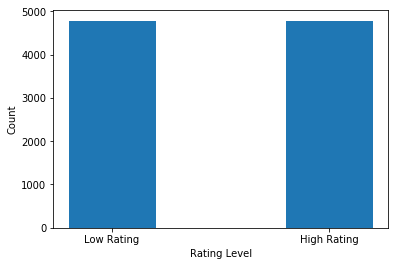

In [35]:
df4 = boost_data.withColumn(
    'RatingLevel',
    when(col('RatingLevel') == 0, 'Low Rating').when(col('RatingLevel') == 1, 'High Rating')
)
boost_data_bar = df4.groupby('RatingLevel').count()
boost_data_x = boost_data_bar.toPandas()['RatingLevel'].values.tolist()
boost_data_y = boost_data_bar.toPandas()['count'].values.tolist()
plt.bar(boost_data_x, boost_data_y, width = 0.4)
plt.xlabel('Rating Level')
plt.ylabel('Count')
plt.show()

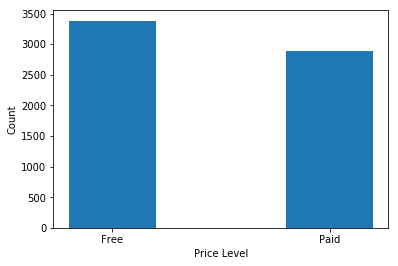

In [36]:
price_level_before = df3_2.withColumn(
    'Price',
    when(col('Price') == 0, 'Free').when(col('Price') > 0, 'Paid')
)
price_level_before_bar = price_level_before.groupby('Price').count()
price_level_before_x = price_level_before_bar.toPandas()['Price'].values.tolist()
price_level_before_y = price_level_before_bar.toPandas()['count'].values.tolist()
plt.bar(price_level_before_x, price_level_before_y, width = 0.4)
plt.xlabel('Price Level')
plt.ylabel('Count')
plt.show()

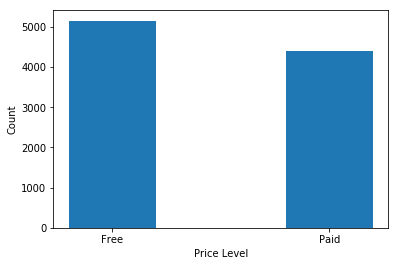

In [37]:
price_level_after = df4.withColumn(
    'Price',
    when(col('Price') == 0, 'Free').when(col('Price') > 0, 'Paid')
)
price_level_after_bar = price_level_after.groupby('Price').count()
price_level_after_x = price_level_after_bar.toPandas()['Price'].values.tolist()
price_level_after_y = price_level_after_bar.toPandas()['count'].values.tolist()
plt.bar(price_level_after_x, price_level_after_y, width = 0.4)
plt.xlabel('Price Level')
plt.ylabel('Count')
plt.show()

In [38]:
print(price_level_before.filter((col('Price')=='Paid')).count()/price_level_before.count() * 100)
print(price_level_after.filter((col('Price')=='Paid')).count()/price_level_after.count() * 100)

46.02744097000638
46.10960050198703


In [39]:
feature_data = df4.select('AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
                          'AppRestriction','AppType','SupportDeviceNum','DisplayedScreenshotNum',
                          'SupportLanguageNum','VppLicense','RatingLevel')
feature_data = feature_data.withColumn(
    'AppRestriction',
    when(col('AppRestriction') == '4+', 1).when(col('AppRestriction') == '12+', 2)
    .when(col('AppRestriction') == '9+', 3).when(col('AppRestriction') == '17+', 4)
)
feature_data = feature_data.withColumn(
    'AppType',
    when(col('AppType') == 'Games', 1).when(col('AppType') == 'Entertainment', 2)
    .when(col('AppType') == 'Education', 3).when(col('AppType') == 'Photo & Video', 4)
    .when(col('AppType') == 'Utilities', 5).when(col('AppType') == 'Social Networking', 6)
    .when(col('AppType') == 'Sports', 7).when(col('AppType') == 'Productivity', 8)
    .when(col('AppType') == 'Health & Fitness', 9).when(col('AppType') == 'Lifestyle', 10)
    .when(col('AppType') == 'Music', 11).when(col('AppType') == 'Shopping', 12)
    .when(col('AppType') == 'Finance', 13).when(col('AppType') == 'Weather', 14)
    .when(col('AppType') == 'News', 15).when(col('AppType') == 'Travel', 16)
    .when(col('AppType') == 'Food & Drink', 17).when(col('AppType') == 'Book', 18)
    .when(col('AppType') == 'Business', 19).when(col('AppType') == 'Reference', 20)
    .when(col('AppType') == 'Navigation', 21).when(col('AppType') == 'Medical', 22)
    .when(col('AppType') == 'Catalogs', 23)
)
feature_data = feature_data.withColumn(
    'RatingLevel',
    when(col('RatingLevel') == 'Low Rating', 0).when(col('RatingLevel') == 'High Rating', 1)
)
feature_data.dtypes

[('AppSize_Bytes', 'double'),
 ('Price', 'double'),
 ('TotalRatingCount', 'double'),
 ('TotalRatingCount_CurrentVersion', 'double'),
 ('AppRestriction', 'int'),
 ('AppType', 'int'),
 ('SupportDeviceNum', 'double'),
 ('DisplayedScreenshotNum', 'bigint'),
 ('SupportLanguageNum', 'double'),
 ('VppLicense', 'bigint'),
 ('RatingLevel', 'int')]

In [40]:
feature_assembler = VectorAssembler(
  inputCols=['AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
             'AppRestriction','AppType','SupportDeviceNum','DisplayedScreenshotNum','SupportLanguageNum','VppLicense'],
              outputCol="Column")
feature_output = feature_assembler.transform(feature_data)
feature_indexer = StringIndexer(inputCol="RatingLevel", outputCol="Output")
feature_output_fixed = feature_indexer.fit(feature_output).transform(feature_output)
final_feature_data = feature_output_fixed.select("Column",'Output')
RF = RandomForestRegressor().setLabelCol('Output').setFeaturesCol('Column').setMaxBins(64).setMaxDepth(16)
feature_model = RF.fit(final_feature_data)
feature_model.featureImportances

SparseVector(10, {0: 0.183, 1: 0.0725, 2: 0.1966, 3: 0.191, 4: 0.0454, 5: 0.1045, 6: 0.0583, 7: 0.0527, 8: 0.094, 9: 0.0019})

In [41]:
df4_1 = df4.select('AppSize_Bytes','Price','TotalRatingCount','TotalRatingCount_CurrentVersion',
                   'AppType','SupportDeviceNum','DisplayedScreenshotNum','SupportLanguageNum','RatingLevel')
print(df4_1.columns)

['AppSize_Bytes', 'Price', 'TotalRatingCount', 'TotalRatingCount_CurrentVersion', 'AppType', 'SupportDeviceNum', 'DisplayedScreenshotNum', 'SupportLanguageNum', 'RatingLevel']


In [42]:
print(df4_1.count(),len(df4_1.columns))

9562 9
